In [1]:
import numpy as np
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
import argparse
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
mvn = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))

x = torch.arange(-3, 3, 0.01)
y = torch.arange(-3, 3, 0.01)
X, Y = torch.meshgrid(x, y)
Z = torch.dstack((X, Y))

log_prob = mvn.log_prob(Z)

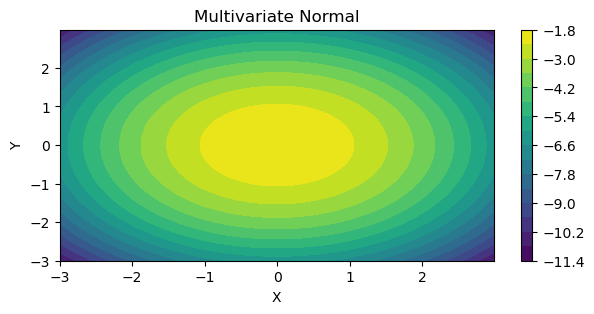

In [3]:
plt.figure(figsize=(7, 3))
plt.contourf(X, Y, log_prob, levels=15)
plt.colorbar()
plt.xlabel(xlabel='X')
plt.ylabel(ylabel='Y')
plt.title('Multivariate Normal')
plt.show()

In [4]:
def log_probs_to_img(dist, extent=None, num=100):

    if extent is None:
        extent = (-3, 3, -3, 3)

    X, Y = torch.meshgrid(torch.linspace(*extent[:2], num), torch.linspace(*extent[2:], num))
    Z = torch.dstack((X, Y))

    log_probs = torch.exp(dist.log_prob(Z))
    
    return X, Y, log_probs, extent

In [5]:
def plot_hmc(samples, positions, momentum, extent):

    collected_samples = np.vstack([tens.detach().numpy() for tens in samples])
    leap_q = [[tens.detach().numpy() for tens in q] for q in positions]
    leap_p = [[tens.detach().numpy() for tens in p] for p in momentum]

    final_q = np.concatenate(leap_q)
    final_p = np.concatenate(leap_p)

    steps = slice(None, None, 20)

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, extent=extent, levels=20)
    plt.quiver(
        final_q[steps, 0], final_q[steps, 1], final_p[steps, 0], final_p[steps, 1], 
        headwidth=5, scale=80, headlength=7
        )
    plt.plot(final_q[:, 0], final_q[:, 1], linestyle='-', lw=2.5, color='black')
    plt.scatter(
        collected_samples[:, 0], collected_samples[:, 1],
        color='red', alpha=0.75
        )

    plt.title('Hamiltonian Monte Carlo');

In [6]:
def leapfrog(q, p, dist, path_len, step_size):
    
    #q, p = q.clone(), p.clone()
    output = -dist.log_prob(q)
    output.backward()
    p -= step_size * q.grad / 2
    q.grad.zero_()

    leap_q = []
    leap_p = []
    for _ in range(int(path_len / step_size) - 1):

        q.grad.zero_()
        with torch.no_grad():
            q += step_size * p
        output = -dist.log_prob(q)
        output.backward()
        p -= step_size * q.grad

        leap_q.append(q.clone())
        leap_p.append(p.clone())
        
    output = -dist.log_prob(q)
    output.backward()
    
    with torch.no_grad():
        q += step_size * p
    
    p -= step_size * q.grad / 2

    return q, -p, leap_q, leap_p

In [7]:
def hamiltonian_monte_carlo(
    n_samples, 
    dist, 
    initial_position,
    path_len=1, 
    step_size=0.1
    ):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    dist : callable
        PyTorch distribution object that can be called
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """    

    # collect all our samples in a list
    samples = [initial_position]
    param_samples = []
    all_leap_q = []
    all_leap_p = []
    # Keep a single object for momentum resampling
    momentum = torch.distributions.Normal(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    size = (n_samples,) + initial_position.shape[:1]
    for idx, p0 in tqdm(enumerate(momentum.sample(size)), total=size[0]):

        q0 = samples[-1]

        # Integrate over our path to get a new position (q_new) and momentum (p_new)
        q_new, p_new, leap_q, leap_p = leapfrog(
            q=q0,
            p=p0,
            dist=dist,
            path_len=2 * np.random.rand() * path_len,
            step_size=step_size
            )

        all_leap_q.append(leap_q)
        all_leap_p.append(leap_p)

        # Check Metropolis acceptance criterion
        start_log_p = torch.sum(momentum.log_prob(p0)) - dist.log_prob(samples[-1])
        new_log_p = torch.sum(momentum.log_prob(p_new)) - dist.log_prob(q_new)
        p_accept = min(1, torch.exp(new_log_p - start_log_p))

        if torch.rand(1) < p_accept:
            param_samples.append(q_new.clone())
        else:
            param_samples.append(q0.clone())
        
    return param_samples, all_leap_q, all_leap_p

100%|██████████| 10/10 [00:00<00:00, 92.83it/s]


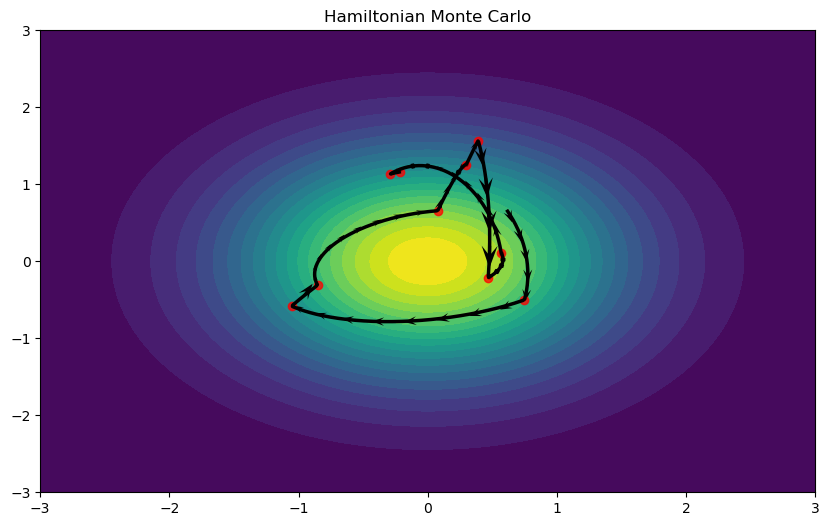

In [10]:
mvn = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
init_pos = torch.randn(2, requires_grad=True)

X, Y, Z, extent = log_probs_to_img(mvn, (-3, 3, -3, 3), num=200)

samples, leap_q, leap_p = hamiltonian_monte_carlo(
    n_samples=10,
    dist=mvn,
    initial_position=init_pos,
    path_len=1,
    step_size=0.01
    )

plot_hmc(samples, leap_q, leap_p, extent)